## Importamos paquetes y librerias

In [65]:
import os
import shutil
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
import numpy as np
import cupy as cp
import cv2 as cv
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from IPython.display import display


## Preparacion del dataset

In [2]:
DATASET_PATH = "../Proyecto/Datasets/archive (5)/AugmentedAlzheimerDataset"
CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [46]:
dataset = image_dataset_from_directory(DATASET_PATH, image_size=IMG_SIZE, batch_size=BATCH_SIZE)

Found 33984 files belonging to 4 classes.


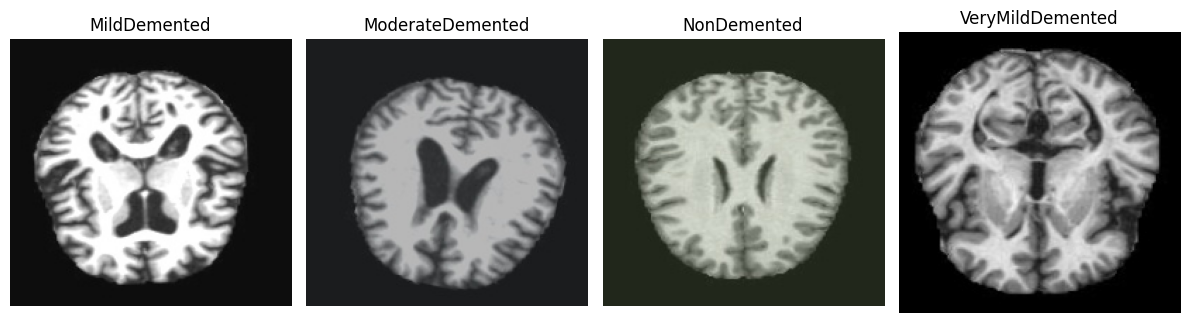

In [47]:
from PIL import Image

# Graficar una imagen de ejemplo por cada clase
plt.figure(figsize=(12, 8))

for i, class_name in enumerate(CLASS_NAMES):
    class_path = os.path.join(DATASET_PATH, class_name)
    image_name = random.choice(os.listdir(class_path))  # Selecciona una imagen aleatoria
    image_path = os.path.join(class_path, image_name)
    
    # Cargar y mostrar la imagen
    img = Image.open(image_path)
    plt.subplot(1, len(CLASS_NAMES), i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [48]:
def analyze_dataset(target_path):

    if not os.path.exists(target_path):
        raise FileNotFoundError(f"The directory '{target_path}' does not exist.")

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'} 
    folder_analysis = {}

    # Revisa imagen por imagen en cada carpeta
    for folder in os.listdir(target_path):
        folder_path = os.path.join(target_path, folder)
        if os.path.isdir(folder_path):
            image_count = 0
            resolutions = set()
            # Revisa cada archivo en la carpeta
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if os.path.splitext(file)[1].lower() in image_extensions:
                    img = cv.imread(file_path)
                    if img is not None:
                        #Obtiene la resolución de la imagen ignoarando el rbg
                        resolutions.add(img.shape[:2])  # (height, width)
                        image_count += 1

            folder_analysis[folder] = {
                "image_count": image_count,
                "unique_resolutions": resolutions
            }

    return folder_analysis

In [49]:
dataset_analysis = analyze_dataset(DATASET_PATH)

for folder, data in dataset_analysis.items():
    print(f"{folder}: {data['image_count']} images, Resolutions: {data['unique_resolutions']}")

# Verifica si el dataset tiene resoluciones inconsistentes
dataset_has_variable_resolutions = any(len(data["unique_resolutions"]) > 1 for data in dataset_analysis.values())

if dataset_has_variable_resolutions:
    print("\n El dataset tiene resoluciones inconsistentes.")
else:
    print("\nEl dataset tiene resolucion uniforme.")

MildDemented: 8960 images, Resolutions: {(180, 180), (190, 200)}
ModerateDemented: 6464 images, Resolutions: {(180, 180), (190, 200)}
NonDemented: 9600 images, Resolutions: {(180, 180), (190, 200)}
VeryMildDemented: 8960 images, Resolutions: {(180, 180), (190, 200)}

 El dataset tiene resoluciones inconsistentes.


###  División del Conjunto de Datos
* 80% Training data
* 20% Validation Data
* OriginalDataset se utiliza para Testing.

In [3]:
TRAIN_SPLIT = 0.8  # 80% Training
VALIDATION_SPLIT = 0.2  # 20% Validation

TRAIN_VALIDATION_DATASET_PATH = "../Proyecto/Datasets/archive (5)/AugmentedAlzheimerDataset"
TESTING_DATASET_PATH = "../Proyecto/Datasets/archive (5)/OriginalDataset"
SPLIT_DATASET_PATH = "../Proyecto/Datasets/archive (5)/split_dataset"

In [51]:
# Crea rutas de salida
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(SPLIT_DATASET_PATH, split), exist_ok=True)

# Separa en Validation y Training
for class_name in os.listdir(TRAIN_VALIDATION_DATASET_PATH):
    class_path = os.path.join(TRAIN_VALIDATION_DATASET_PATH, class_name)

    if not os.path.isdir(class_path):
        continue  #

    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(images) 

    # Calcula el tamaño del train
    total_images = len(images)
    train_size = int(TRAIN_SPLIT * total_images)

    # Asigna imagenes a training y validation
    for i, img in enumerate(images):
        src_path = os.path.join(class_path, img)

        if i < train_size:
            dst_path = os.path.join(SPLIT_DATASET_PATH, "train", class_name)
        else:
            dst_path = os.path.join(SPLIT_DATASET_PATH, "val", class_name)

        os.makedirs(dst_path, exist_ok=True)
        shutil.copy2(src_path, os.path.join(dst_path, img))

    print(f" Processed {class_name}: {total_images} images (Train: {train_size}, Val: {total_images - train_size})")

 Processed MildDemented: 8960 images (Train: 7168, Val: 1792)
 Processed ModerateDemented: 6464 images (Train: 5171, Val: 1293)
 Processed NonDemented: 9600 images (Train: 7680, Val: 1920)
 Processed VeryMildDemented: 8960 images (Train: 7168, Val: 1792)


In [52]:
# Copia el testing data sin el split
for class_name in os.listdir(TESTING_DATASET_PATH):
    class_path = os.path.join(TESTING_DATASET_PATH, class_name)

    if not os.path.isdir(class_path):
        continue

    dst_path = os.path.join(SPLIT_DATASET_PATH, "test", class_name)
    os.makedirs(dst_path, exist_ok=True)

    for img in os.listdir(class_path):
        if img.lower().endswith(('.jpg', '.jpeg', '.png')):
            src_path = os.path.join(class_path, img)
            shutil.copy2(src_path, os.path.join(dst_path, img))

    print(f"Copiadas las Imagenes de {class_name} test images.")

print(" Dataset exitosamente separado en train (80%), validation (20%), test (OriginalDataset)")

Copiadas las Imagenes de MildDemented test images.
Copiadas las Imagenes de ModerateDemented test images.
Copiadas las Imagenes de NonDemented test images.
Copiadas las Imagenes de VeryMildDemented test images.
 Dataset exitosamente separado en train (80%), validation (20%), test (OriginalDataset)


## Distribucion del conjunto de datos

In [53]:
def count_images(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return class_counts

In [54]:
# Cuenta las imagenes por split
train_counts = count_images(os.path.join(SPLIT_DATASET_PATH, "train"))
validation_counts = count_images(os.path.join(SPLIT_DATASET_PATH, "val"))
test_counts = count_images(os.path.join(SPLIT_DATASET_PATH, "test"))

In [55]:
df = pd.DataFrame({
    "Train": train_counts,
    "Validation": validation_counts,
    "Test": test_counts
}).T

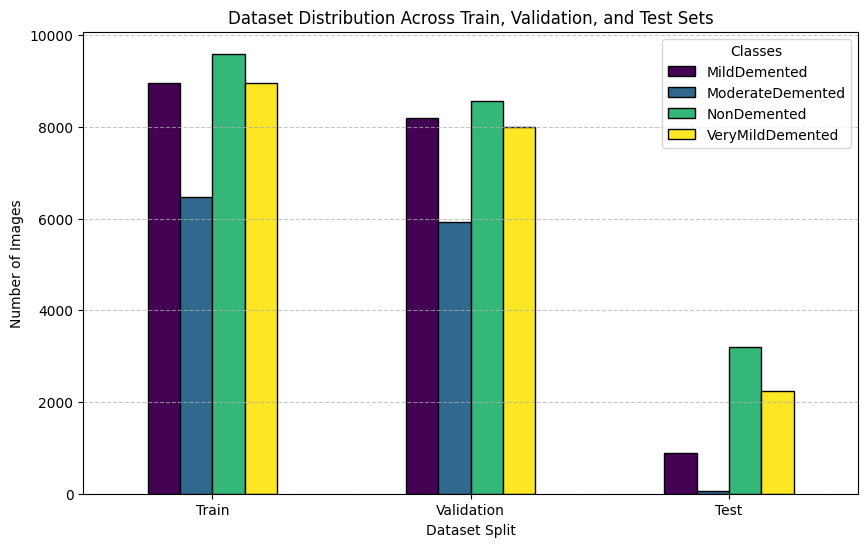

In [56]:
#Grafica la distribucion del dataset
df.plot(kind="bar", figsize=(10, 6), colormap="viridis", edgecolor="black")
plt.title("Dataset Distribution Across Train, Validation, and Test Sets")
plt.xlabel("Dataset Split")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)
plt.legend(title="Classes")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


# Carga de datos
1. Utiliza image_dataset_from_directory() con etiquetado automático de clases.
2. Garantiza **shuffle=True** para los conjuntos de entrenamiento y validación, mientras que **mantiene el conjunto de prueba sin mezclar**.
3. Incluye **BATCH_SIZE=32** correcto para un entrenamiento eficiente.
4. Añade AUTOTUNE para un mejor rendimiento al cargar el conjunto de datos.

In [57]:
AUTOTUNE = tf.data.AUTOTUNE  # Para precarga de datos mas optimizada

# Carga de datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(SPLIT_DATASET_PATH, "train"),
    image_size=IMG_SIZE,
    batch_size=None,
    shuffle=True,
    seed=42
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(SPLIT_DATASET_PATH, "val"),
    image_size=IMG_SIZE,
    batch_size=None, 
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(SPLIT_DATASET_PATH, "test"),
    image_size=IMG_SIZE,
    batch_size=None, 
    shuffle=True
)


train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"Dataset cargado")
print(f"Train: {train_size} imagenes, Validation: {val_size} imagenes, Test: {test_size} imagenes")


Found 33984 files belonging to 4 classes.
Found 30696 files belonging to 4 classes.
Found 6400 files belonging to 4 classes.
Dataset cargado
Train: 33984 imagenes, Validation: 30696 imagenes, Test: 6400 imagenes


# Preprocesamiento de datos
* Convierte el tipo de datos de imagen a tf.float32 y normaliza los valores de píxel al rango [0,1].
* Redimensiona todas las imágenes a (224,224) para mantener la consistencia en todo el conjunto de datos.
* Utiliza .map() para aplicar preprocesamiento a los conjuntos de datos de entrenamiento, validación y prueba.
* El conjunto de datos ya está aumentado, por lo que no es necesario aumentarlo.

**Optimización**
* La redistribución (solo para entrenamiento) garantiza una mejor generalización.
* El procesamiento por lotes agrupa las imágenes en minilotes para un procesamiento eficiente en la GPU.
* La precarga permite que el modelo cargue datos de forma asíncrona, lo que acelera el entrenamiento.

In [58]:
BUFFER_SIZE = 1000

def preprocess_image(image, label):
    with tf.device('/GPU:0'):  
        image = tf.image.resize(image, IMG_SIZE) #Redimensiona la imagen
        image = tf.image.convert_image_dtype(image, tf.float32) #Convierte la imagen a float32
    return image, label

# Aplica preprocesamiento a los datasets
train_dataset = train_dataset.map(preprocess_image)
val_dataset = val_dataset.map(preprocess_image)
test_dataset = test_dataset.map(preprocess_image)

# Mezcla el dataset y lo carga en batches
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE) 
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Verifica el tamaño de los datasets
print(" Dataset listo para training")
print(f"Total de Imagenes: {train_size + val_size + test_size}")
print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")

 Dataset listo para training
Total de Imagenes: 71080
Train: 33984, Validation: 30696, Test: 6400


In [59]:
def check_image_size(dataset, dataset_name):
    for image_batch, _ in dataset.take(1):  # Usa el primer batch
        print(f" {dataset_name} Sample Image Shape: {image_batch.shape}")  


# Verifica para cada dataset
check_image_size(train_dataset, "Train")
check_image_size(val_dataset, "Validation")
check_image_size(test_dataset, "Test")
# Expected output: (BATCH_SIZE, 224, 224, 3)

 Train Sample Image Shape: (32, 224, 224, 3)


2025-04-04 11:25:18.719220: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


 Validation Sample Image Shape: (32, 224, 224, 3)
 Test Sample Image Shape: (32, 224, 224, 3)


2025-04-04 11:25:18.982116: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Modelo

1. Utiliza Callbacks para detener el entrenamiento anticipadamente si la precisión alcanza el 95 % o si no se observa ninguna mejora.

2. Construye un modelo CNN utilizando Keras con batch normalization y dropout.

3. Compila el modelo con el Adam Optimizer y Crossentropy.

4. Entrena el modelo con el conjunto de datos procesado.

**Mejoras en la arquitectura del modelo**
* Batch Normalization después de cada Conv2D para una mayor estabilidad.
* Dropout (0,5) antes de la salida para evitar overfitting.
* Capa de salida Softmax (ya que hay 4 clases).
* Utiliza MaxPooling2D para reducir el tamaño del mapa de características.
* Adam Optimizer (learning rate = 0,001) para aprendizaje adaptativo.
* Categorical Crossentropy → Funciona con int labels (en lugar de codificación one-hot).

**Detención temprana y reducción de la precisión de validación**
* early_stop_loss: Detiene el entrenamiento si validation_loss no mejora durante 5 épocas.
* reduce_lr: Reduce el learning rate en un factor de 0,2 si no mejora durante 3 épocas.
* early_stop_acc: Detiene el entrenamiento si validation accuracy se estanca durante 5 épocas.
* stop_at_95: Detiene el entrenamiento inmediatamente si validation accuracy alcanza el 95 %.

In [70]:
# Detiene el entrenamiento si validation_loss no mejora en 5 epochs
early_stop_loss = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
)

# Reduce learning rate si validation loss se estanca por 3 epochs
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1
)

# Detiene entrenamiento si validation accuracy no mejora en 5 epochs
early_stop_acc = callbacks.EarlyStopping(
    monitor='val_accuracy', patience=5, min_delta=0.001, mode='max', 
    verbose=1, restore_best_weights=True
)

# Custom Callback: Stop training if val_accuracy reaches 95%
class StopAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy=0.95):
        super(StopAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy') >= self.target_accuracy:
            print(f"\n✅ Target val_accuracy {self.target_accuracy * 100:.1f}% reached, stopping training!")
            self.model.stop_training = True

stop_at_95 = StopAtAccuracy(target_accuracy=0.965)

In [66]:
model = keras.Sequential([
    
    layers.InputLayer(shape=(224, 224, 3)),
    # Conv Block 1
    layers.Conv2D((32), (3,3), activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    # Conv Block 2
    layers.Conv2D(64, (3,3), activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    # Conv Block 3
    layers.Conv2D(128, (3,3), activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    # Conv Block 4
    layers.Conv2D(256, (3,3), activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    # Conv Block 5
    layers.Conv2D(512, (3,3), activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2,2),

    # Flatten and Fully Connected Layers
    layers.Flatten(),
    layers.Dense(128, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),  # Dropout for regularization

    # Output Layer (4 Classes, Softmax Activation)
    layers.Dense(4, activation='softmax')
])


In [61]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 222, 222, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 52, 52, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10, 10, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,212,100 (12.25 MB)

 Trainable params: 3,209,860 (12.24 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [79]:
for images, labels in train_dataset.take(1):
    print(images.shape)  # Should print something like (batch_size, 224, 224, 3)


(32, 224, 224, 3)


In [80]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
EPOCHS = 50

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[early_stop_acc, early_stop_loss, reduce_lr, stop_at_95]
)

Epoch 1/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 211s 193ms/step - accuracy: 0.6172 - loss: 0.8955 - val_accuracy: 0.8413 - val_loss: 0.3942 - learning_rate: 0.0010
Epoch 2/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 214s 201ms/step - accuracy: 0.8955 - loss: 0.2771 - val_accuracy: 0.9407 - val_loss: 0.1568 - learning_rate: 0.0010
Epoch 3/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 213s 195ms/step - accuracy: 0.9438 - loss: 0.1492 - val_accuracy: 0.8649 - val_loss: 0.3131 - learning_rate: 0.0010
Epoch 4/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 136s 127ms/step - accuracy: 0.9644 - loss: 0.0994 - val_accuracy: 0.9537 - val_loss: 0.1243 - learning_rate: 0.0010
Epoch 5/50
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9750 - loss: 0.0687
✅ Target val_accuracy 96.5% reached, stopping training!
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 139s 130ms/step - accuracy: 0.9750 - loss: 0.0687 - val_accuracy: 0.9900 - val_loss: 0.0310 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.
Restoring model 

## Evaluacion del modelo

In [83]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.9959 - loss: 0.0153
Test Accuracy: 0.9962, Test Loss: 0.0156



Classification Report:

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       896
ModerateDemented       1.00      1.00      1.00        64
     NonDemented       1.00      0.99      1.00      3200
VeryMildDemented       0.99      1.00      0.99      2240

        accuracy                           1.00      6400
       macro avg       1.00      1.00      1.00      6400
    weighted avg       1.00      1.00      1.00      6400



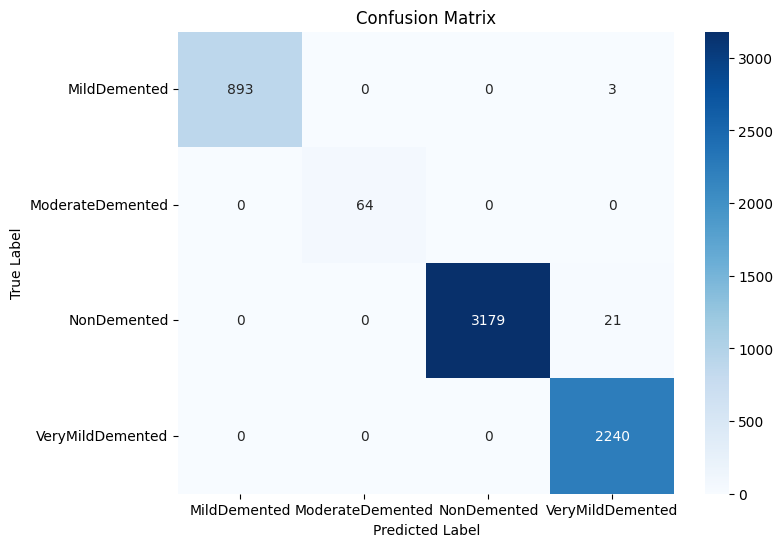

In [84]:
true_labels = []
pred_labels = []

for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)  
    predicted_classes = np.argmax(predictions, axis=1)
    
    true_labels.extend(labels.numpy()) 
    pred_labels.extend(predicted_classes) 

#Genera Classification Report
print("\nClassification Report:\n")
print(classification_report(true_labels, pred_labels, target_names=CLASS_NAMES))

# Genera matriz de confusión
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Grafica confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

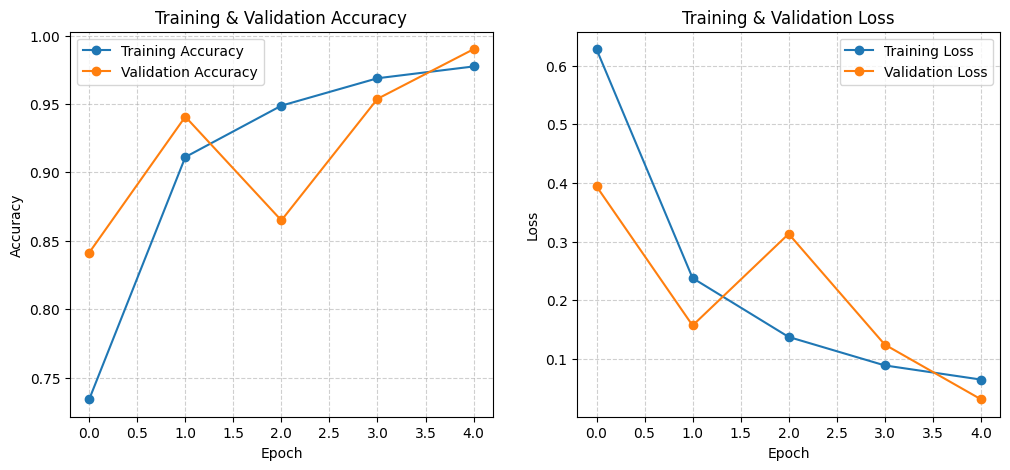

In [92]:
#Grafica las curvas de accuracy y loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Grafica Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.title('Training & Validation Accuracy')

    # Grafica Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.title('Training & Validation Loss')

    plt.show()
    
plot_training_history(history)

## Guardar Modelo

In [86]:
#Guardamos modelos como keras
model.save("alzheimer_model2.keras")
print("Model guardado como .keras")

Model guardado como .keras


## Predicciones

In [10]:
# Carga del modelo

MODEL_PATH = "../Proyecto/alzheimer_model2.keras"
model = tf.keras.models.load_model(MODEL_PATH)

In [11]:
#Preprocesamiento de imagenes para la prediccion
def preprocess_image(image):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

In [36]:
MODEL_PATH = "../Proyecto/alzheimer_model2.keras"  
model = tf.keras.models.load_model(MODEL_PATH)

#Escoge una imagen aleatoria del dataset de testing
def get_random_test_image():
    random_class = random.choice(CLASS_NAMES)  
    class_path = os.path.join(TESTING_DATASET_PATH, random_class)
    image_name = random.choice(os.listdir(class_path))  
    return os.path.join(class_path, image_name), random_class  
    
#Funcion para prediccion de imagenes
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224))
    
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = preprocess_image(image)  
    image = tf.expand_dims(image, axis=0)

    predictions = model(image, training=False) 
    predicted_class = CLASS_NAMES[tf.argmax(predictions, axis=-1).numpy()[0]]
    confidence = tf.reduce_max(predictions).numpy() * 100
    
    return predicted_class, confidence

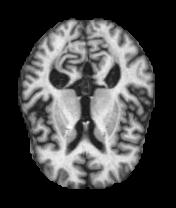


**Actual Class:** ModerateDemented
**Predicted Class:** ModerateDemented



In [44]:
from PIL import Image

#Prediccion en imagen random
random_image_path, actual_class = get_random_test_image()
display(Image.open(random_image_path))

# Run prediction
predicted_class, confidence = predict_image(random_image_path)
print(f"\n**Actual Class:** {actual_class}")
print(f"**Predicted Class:** {predicted_class}\n")



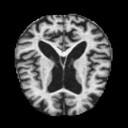


**Actual Class:** ModerateDemented
**Predicted Class:** ModerateDemented



In [53]:
from PIL import Image

image_path="../Proyecto/imagenes_externas/moderate_demented.png"
display(Image.open(image_path))

predicted_class, confidence = predict_image(image_path)
print(f"\n**Actual Class:** {actual_class}")
print(f"**Predicted Class:** {predicted_class}\n")
